## Final Machine Learning Pipeline

The pipeline features

- open source classes
- in house package classes
- only uses the selected features
- we score new data


In [37]:
# data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for saving the pipeline
import joblib

# from Scikit-learn
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer

# from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import LogTransformer

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

import preprocessors as pp

In [38]:
# load dataset
data = pd.read_csv('data/house_prices/train.csv')

# rows and columns of the data
print(data.shape)

# visualise the dataset
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [39]:
# Cast MSSubClass as object
data['MSSubClass'] = data['MSSubClass'].astype('O')

## Train-test split

In [40]:
# Let's separate into train and test set
# Remember to set the seed (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1),
    data['SalePrice'], 
    test_size=0.1, 
    random_state=0,
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

## Target 

In [41]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Config

In [42]:
# categorical variables with NA in train set
CATEGORICAL_VARS_WITH_NA_FREQUENT = ['BsmtQual', 'BsmtExposure',
                                     'BsmtFinType1', 'GarageFinish']


CATEGORICAL_VARS_WITH_NA_MISSING = ['FireplaceQu']


# numerical variables with NA in train set
NUMERICAL_VARS_WITH_NA = ['LotFrontage']


TEMPORAL_VARS = ['YearRemodAdd']
REF_VAR = "YrSold"

# this variable is to calculate the temporal variable,
# can be dropped afterwards
DROP_FEATURES = ["YrSold"]

# variables to log transform
NUMERICALS_LOG_VARS = ["LotFrontage", "1stFlrSF", "GrLivArea"]


# variables to binarize
BINARIZE_VARS = ['ScreenPorch']

# variables to map
QUAL_VARS = ['ExterQual', 'BsmtQual',
             'HeatingQC', 'KitchenQual', 'FireplaceQu']

EXPOSURE_VARS = ['BsmtExposure']

FINISH_VARS = ['BsmtFinType1']

GARAGE_VARS = ['GarageFinish']

FENCE_VARS = ['Fence']


# categorical variables to encode
CATEGORICAL_VARS = ['MSSubClass',  'MSZoning',  'LotShape',  'LandContour',
                    'LotConfig', 'Neighborhood', 'RoofStyle', 'Exterior1st',
                    'Foundation', 'CentralAir', 'Functional', 'PavedDrive',
                    'SaleCondition']


# variable mappings
QUAL_MAPPINGS = {'Po': 1, 'Fa': 2, 'TA': 3,
                 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

EXPOSURE_MAPPINGS = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

FINISH_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1,
                   'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

GARAGE_MAPPINGS = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}


# the selected variables
FEATURES = [
    'MSSubClass',
    'MSZoning',
    'LotFrontage',
    'LotShape',
    'LandContour',
    'LotConfig',
    'Neighborhood',
    'OverallQual',
    'OverallCond',
    'YearRemodAdd',
    'RoofStyle',
    'Exterior1st',
    'ExterQual',
    'Foundation',
    'BsmtQual',
    'BsmtExposure',
    'BsmtFinType1',
    'HeatingQC',
    'CentralAir',
    '1stFlrSF',
    '2ndFlrSF',
    'GrLivArea',
    'BsmtFullBath',
    'HalfBath',
    'KitchenQual',
    'TotRmsAbvGrd',
    'Functional',
    'Fireplaces',
    'FireplaceQu',
    'GarageFinish',
    'GarageCars',
    'GarageArea',
    'PavedDrive',
    'WoodDeckSF',
    'ScreenPorch',
    'SaleCondition',
    # this one is only to calculate temporal variable:
    "YrSold",
]

In [43]:
X_train = X_train[FEATURES]
X_test = X_test[FEATURES]

X_train.shape, X_test.shape

((1314, 37), (146, 37))

## Pipeline

In [44]:
# set up the pipeline
price_pipe = Pipeline([

    # ===== IMPUTATION =====
    # impute categorical variables with string missing
    ('missing_imputation', CategoricalImputer(
        imputation_method='missing', variables=CATEGORICAL_VARS_WITH_NA_MISSING)),

    ('frequent_imputation', CategoricalImputer(
        imputation_method='frequent', variables=CATEGORICAL_VARS_WITH_NA_FREQUENT)),

    # add missing indicator
    ('missing_indicator', AddMissingIndicator(variables=NUMERICAL_VARS_WITH_NA)),

    # impute numerical variables with the mean
    ('mean_imputation', MeanMedianImputer(
        imputation_method='mean', variables=NUMERICAL_VARS_WITH_NA
    )),
    
    
    # == TEMPORAL VARIABLES ====
    ('elapsed_time', pp.TemporalVariableTransformer(
        variables=TEMPORAL_VARS, reference_variable=REF_VAR)),

    ('drop_features', DropFeatures(features_to_drop=[REF_VAR])),

   

    # ==== VARIABLE TRANSFORMATION =====
    ('log', LogTransformer(variables=NUMERICALS_LOG_VARS)),
    
#     ('yeojohnson', YeoJohnsonTransformer(variables=NUMERICALS_YEO_VARS)),
    
    ('binarizer', SklearnTransformerWrapper(
        transformer=Binarizer(threshold=0), variables=BINARIZE_VARS)),
    

    # === mappers ===
    ('mapper_qual', pp.Mapper(
        variables=QUAL_VARS, mappings=QUAL_MAPPINGS)),

    ('mapper_exposure', pp.Mapper(
        variables=EXPOSURE_VARS, mappings=EXPOSURE_MAPPINGS)),

    ('mapper_finish', pp.Mapper(
        variables=FINISH_VARS, mappings=FINISH_MAPPINGS)),

    ('mapper_garage', pp.Mapper(
        variables=GARAGE_VARS, mappings=GARAGE_MAPPINGS)),
    
#     ('mapper_fence', pp.Mapper(
#         variables=FENCE_VARS, mappings=FENCE_MAPPINGS)),


    # == CATEGORICAL ENCODING
    ('rare_label_encoder', RareLabelEncoder(
        tol=0.01, n_categories=1, variables=CATEGORICAL_VARS
    )),

    # encode categorical and discrete variables using the target mean
    ('categorical_encoder', OrdinalEncoder(
        encoding_method='ordered', variables=CATEGORICAL_VARS)),
    
    
    ('scaler', MinMaxScaler()),
#     ('selector', SelectFromModel(Lasso(alpha=0.001, random_state=0))), # <- don't include selection in pipeline
    ('Lasso', Lasso(alpha=0.001, random_state=0)),
])

In [45]:
# train the pipeline
price_pipe.fit(X_train, y_train)

Pipeline(steps=[('missing_imputation',
                 CategoricalImputer(variables=['FireplaceQu'])),
                ('frequent_imputation',
                 CategoricalImputer(imputation_method='frequent',
                                    variables=['BsmtQual', 'BsmtExposure',
                                               'BsmtFinType1',
                                               'GarageFinish'])),
                ('missing_indicator',
                 AddMissingIndicator(variables=['LotFrontage'])),
                ('mean_imputation',
                 MeanMedianImputer(imputation_method=...
                                             'Foundation', 'CentralAir',
                                             'Functional', 'PavedDrive',
                                             'SaleCondition'])),
                ('categorical_encoder',
                 OrdinalEncoder(variables=['MSSubClass', 'MSZoning', 'LotShape',
                                           'LandContour',

In [46]:
# evaluate the model:
# ====================

# make predictions for train set
pred = price_pipe.predict(X_train)

# determine mse, rmse and r2
print('Train MSE: \t{}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('Train RMSE: \t{}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('Train R2: \t{}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# make predictions for test set
pred = price_pipe.predict(X_test)

# determine mse, rmse and r2
print('Test MSE: \t{}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('Test RMSE: \t{}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('Test R2: \t{}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

Train MSE: 	781396630
Train RMSE: 	27953
Train R2: 	0.8748530315439078

Test MSE: 	1060769014
Test RMSE: 	32569
Test R2: 	0.8456415571208442

Average house price:  163000


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

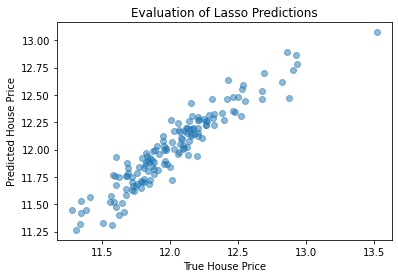

In [47]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, price_pipe.predict(X_test), alpha=0.5)
plt.xlabel('True House Price')
plt.ylabel('Predicted House Price')
plt.title('Evaluation of Lasso Predictions')

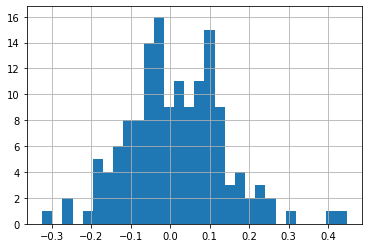

In [48]:
# let's evaluate the distribution of the errors: 
# they should be fairly normally distributed

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(price_pipe.predict(X_test))

errors = y_test - preds
errors.hist(bins=30)
plt.show()

In [49]:
# now let's save the scaler
joblib.dump(price_pipe, 'models/price_pipe.joblib')

['models/price_pipe.joblib']

In [50]:
# load the unseen / new dataset
data = pd.read_csv('data/house_prices/test.csv')
data.drop('Id', axis=1, inplace=True)
data['MSSubClass'] = data['MSSubClass'].astype('O')

data = data[FEATURES] # filter implemented features

print(data.shape)

(1459, 37)


In [51]:
new_vars_with_na = [
    var for var in FEATURES
    
    if var not in (
        CATEGORICAL_VARS_WITH_NA_FREQUENT +
        CATEGORICAL_VARS_WITH_NA_MISSING +
        NUMERICAL_VARS_WITH_NA
    )
    and data[var].isnull().sum() > 0]

In [52]:
new_vars_with_na

['MSZoning',
 'Exterior1st',
 'BsmtFullBath',
 'KitchenQual',
 'Functional',
 'GarageCars',
 'GarageArea']

In [53]:
data[new_vars_with_na].head()

,MSZoning,Exterior1st,BsmtFullBath,KitchenQual,Functional,GarageCars,GarageArea
0,RH,VinylSd,0.0,TA,Typ,1.0,730.0
1,RL,Wd Sdng,0.0,Gd,Typ,1.0,312.0
2,RL,VinylSd,0.0,TA,Typ,2.0,482.0
3,RL,VinylSd,0.0,Gd,Typ,2.0,470.0
4,RL,HdBoard,0.0,Gd,Typ,2.0,506.0


In [54]:
data[new_vars_with_na].isnull().mean()

MSZoning        0.002742
Exterior1st     0.000685
BsmtFullBath    0.001371
KitchenQual     0.000685
Functional      0.001371
GarageCars      0.000685
GarageArea      0.000685
dtype: float64

In [55]:
data[new_vars_with_na].isnull().sum()

MSZoning        4
Exterior1st     1
BsmtFullBath    2
KitchenQual     1
Functional      2
GarageCars      1
GarageArea      1
dtype: int64

(1459, 37)

In [56]:
print('before dropping NA:\t', data.shape)
data.dropna(subset=new_vars_with_na, inplace=True)
print('after dropping NA:\t', data.shape)

before dropping NA:	 (1459, 37)
after dropping NA:	 (1449, 37)


In [57]:
new_preds = price_pipe.predict(data)

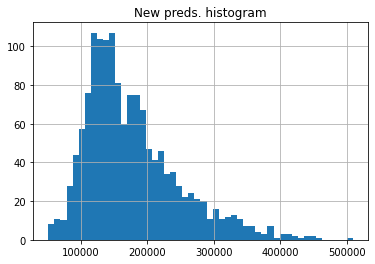

In [60]:
# let's plot the predicted sale prices
pd.Series(np.exp(new_preds)).hist(bins=50)
plt.title('New preds. histogram');

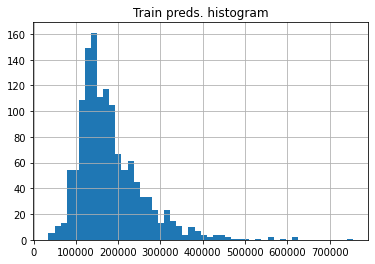

In [61]:
# let's plot the predicted sale prices
pd.Series(np.exp(y_train)).hist(bins=50)
plt.title('Train preds. histogram');

## Conclusion

Now we are ready for deployment (!!!)